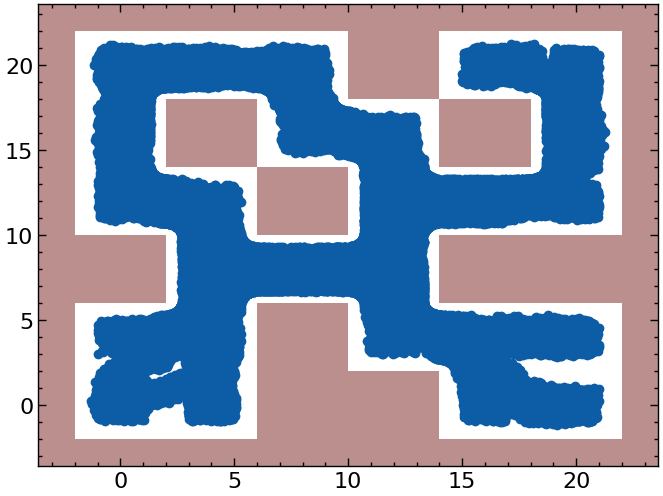

In [1]:
# MISC
import os
import sys
sys.path.append("..")

os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='0'

from rich.pretty import pprint
# import shutup
# shutup.please()

import numpy as np

# RL 
import jax
import jax.numpy as jnp
import gymnasium
import ogbench
import ogbench.online_locomotion.wrappers
import flax.linen as nn

# Custom
from envs.ogbench.ant_utils import MazeVizWrapper, plot_value
from utils.datasets import Dataset, GCDataset
from agents.fb import get_config, ForwardBackwardAgent

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
plt.style.use(['science', 'notebook'])

GLOBAL_KEY = jax.random.key(42)

# Use either exising dataset or create from data_gen_scripts
# 'pointmaze-medium-explore-v0'
# env = ogbench.make_env_and_datasets( #  train_dataset, valid_dataset 
#     "pointmaze-medium-explore-v0",
#     env_only=True, render_mode='rgb_array'
# )
env, train_dataset, valid_dataset = ogbench.make_env_and_datasets( #  train_dataset, valid_dataset 
    "pointmaze-medium-stitch-v0",
    env_only=False
)
obs, info = env.reset()
env = MazeVizWrapper(env)
train_dataset = Dataset.create(**train_dataset)
#pointmaze_explore_data = np.load("/home/m_bobrin/ZeroShotRL/aux_data/pointmaze-medium-explore-v0.npz")
fig, ax = plt.subplots()

polygons = env.draw(ax=ax)

#ax.scatter(pointmaze_explore_data['observations'][:, 0], pointmaze_explore_data['observations'][:, 1])
ax.scatter(train_dataset['observations'][:, 0], train_dataset['observations'][:, 1])

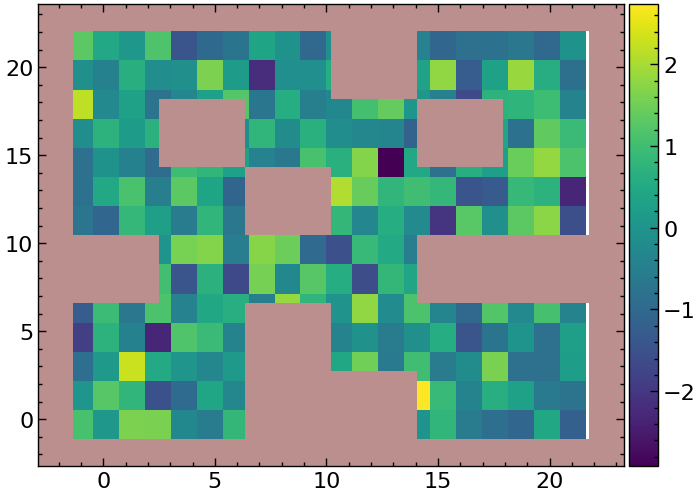

In [4]:
fig, ax = plt.subplots()
ax.scatter(*info['goal'], c='red')
plot_value(env, train_dataset, value_fn=lambda x: np.random.normal(size=x.shape[0]), fig=fig, ax=ax)

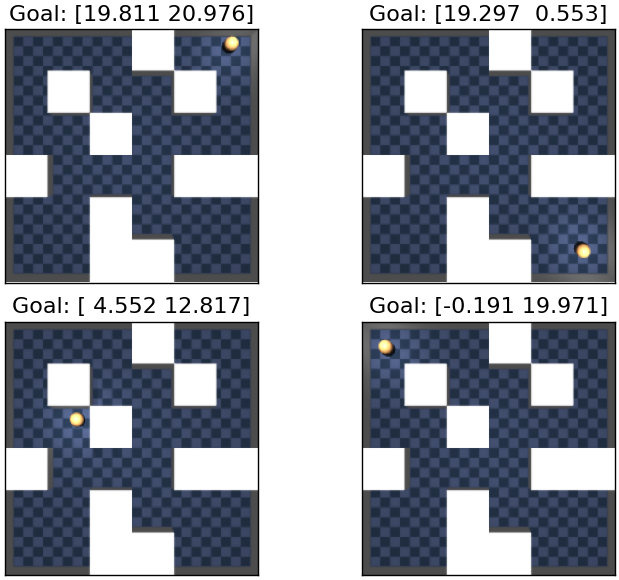

In [5]:
fig, axs = plt.subplots(ncols=2, nrows=2)
axs = axs.flatten()
for idx, task_id in enumerate([1, 2, 3, 4]):
    ob, info = env.reset(
        options=dict(
            task_id=task_id,
            render_goal=True,
        )
    )
    goal = info['goal']
    goal_rendered = info['goal_rendered']
    axs[idx].imshow(goal_rendered)
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].set_title(f"Goal: {np.round(goal, 3)}")
plt.tight_layout()